In [121]:
import lightgbm as lgb, catboost as cb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
# pd.options.display.max_rows = 100

# Prepare data and make some features

In [122]:
df_train = pd.read_csv('train.csv').sort_values('create_time')
df_train.create_time = pd.to_datetime(df_train.create_time, errors='raise')
df_train.model_create_time = pd.to_datetime(df_train.model_create_time, errors='raise')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104595 entries, 87721 to 84902
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            104595 non-null  int64         
 1   create_time         104595 non-null  datetime64[ns]
 2   good_id             104595 non-null  int64         
 3   price               104595 non-null  int64         
 4   utm_medium          104595 non-null  int64         
 5   utm_source          94145 non-null   float64       
 6   sessionkey_id       104595 non-null  int64         
 7   category_id         104595 non-null  int64         
 8   parent_id           104595 non-null  int64         
 9   root_id             104595 non-null  int64         
 10  model_id            104595 non-null  int64         
 11  is_moderated        104595 non-null  int64         
 12  rating_value        33741 non-null   float64       
 13  rating_count        51613 non-n

In [123]:
df_train['is_rated'] = df_train['rating_value'].isna().astype(int)

In [124]:
df_train.head()

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated
87721,1158405,1975-11-01 09:00:05,60503617,584,5,13.0,112851257,1505,2844,1504,26989476,1,NaN,0.0,0,1,1,1975-07-31 03:06:45,0,1
13972,1158407,1975-11-01 09:09:56,55560055,662,1,2.0,112848617,1214,1213,1183,520544,1,5.0,2.0,169,12,2,1972-04-14 18:23:15,0,0
90161,1158408,1975-11-01 09:10:58,65031170,510,2,NaN,112851658,4455,4448,255,27815897,1,NaN,1.0,1921,2,1,1975-08-22 14:02:07,0,1
69290,1158409,1975-11-01 09:14:53,58615677,787,1,2.0,112848617,3548,2646,1183,16747208,1,NaN,0.0,382,5,1,1974-11-25 15:23:06,0,1
4188,1158410,1975-11-01 09:15:47,21297938,1433,1,2.0,112673919,2449,1212,1183,145731,1,4.0,12.0,926,24,16,1971-10-06 16:26:25,0,0


In [125]:
len(df_train.order_id.unique()),len(df_train.sessionkey_id.unique())

(104595, 96803)

In [126]:
df_train.sessionkey_id.value_counts()[0:30]

sessionkey_id
125996889    21
116065921    17
115530395    14
125861300    11
113590234    10
119684247    10
126035495    10
128529803     9
113182406     9
121292271     8
127589242     8
116877317     8
115863881     8
116309376     7
131455791     7
118929307     7
114672760     7
113209181     7
124842672     6
124338664     6
114856740     6
122948372     6
126175213     6
119146092     6
115394758     6
125089018     6
125661648     6
121671411     6
129229186     6
127768646     6
Name: count, dtype: int64

In [127]:
df_train[df_train.sessionkey_id ==116065921 ]

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated
66064,1192969,1975-11-18 13:18:32,22383899,1430,5,8.0,116065921,138,133,124,15455093,1,NaN,0.0,67,3,1,1974-10-11 00:44:05,0,1
69847,1192976,1975-11-18 13:20:52,32010052,2659,5,8.0,116065921,1636,1635,1634,16985255,1,NaN,NaN,0,1,1,1974-12-09 22:38:52,0,1
92163,1192979,1975-11-18 13:21:27,62305953,342,5,8.0,116065921,4131,4130,1634,28793900,0,NaN,NaN,250,1,1,1975-09-04 20:09:18,0,1
31702,1192980,1975-11-18 13:21:54,4732511,84,5,8.0,116065921,4137,4135,1634,2602893,1,NaN,NaN,269,1,1,1973-03-09 04:55:17,0,1
75147,1192982,1975-11-18 13:22:20,63994371,1401,5,8.0,116065921,2353,2342,1634,18450679,1,NaN,NaN,466,4,2,1975-02-12 12:08:14,0,1
65578,1193005,1975-11-18 13:27:26,21969072,74,5,8.0,116065921,4138,4135,1634,15278810,0,NaN,NaN,1361,1,1,1974-09-26 22:52:31,0,1
39236,1193010,1975-11-18 13:27:59,3679228,486,5,8.0,116065921,4136,4135,1634,4052118,1,NaN,NaN,425,1,1,1973-09-10 22:07:29,0,1
68212,1193023,1975-11-18 13:30:51,59070927,62,5,8.0,116065921,4141,4129,1634,16472529,0,NaN,NaN,0,1,1,1974-11-08 11:20:02,0,1
38647,1193026,1975-11-18 13:31:20,24956651,1092,5,8.0,116065921,4132,4130,1634,3998422,1,5.0,1.0,0,1,2,1973-09-04 20:33:02,0,0
52378,1193027,1975-11-18 13:31:53,57731635,414,5,8.0,116065921,4107,4106,1634,9727970,1,NaN,NaN,704,2,2,1974-03-22 18:50:37,0,1


In [128]:
df_train['create_time_hour'] = df_train.create_time.dt.hour
df_train['create_time_day'] = df_train.create_time.dt.day
df_train['create_time_month'] = df_train.create_time.dt.month
df_train['model_create_time_hour'] = df_train.model_create_time.dt.hour
df_train['model_create_time_day'] = df_train.model_create_time.dt.day
df_train['model_create_time_month'] = df_train.model_create_time.dt.month
df_train['model_create_time_year'] = df_train.model_create_time.dt.year

In [129]:
df_info =pd.read_csv("t1_webstat.csv").sort_values('date_time')
df_info.date_time = pd.to_datetime(df_info.date_time, errors='raise')
df_info.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3334243 entries, 2268917 to 2059781
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   sessionkey_id          int64         
 1   date_time              datetime64[ns]
 2   page_type              int64         
 3   pageview_number        int64         
 4   pageview_duration_sec  float64       
 5   category_id            float64       
 6   model_id               float64       
 7   good_id                float64       
 8   price                  float64       
 9   product_in_sale        float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 279.8 MB


In [130]:
df_info[df_info.sessionkey_id==116065921]

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2920360,116065921,1975-11-18 11:39:47.830,1,1,39.0,1636.0,13068020.0,32010083.0,2245.0,1.0
2868587,116065921,1975-11-18 11:40:26.570,2,2,332.0,1636.0,NaN,NaN,NaN,NaN
2868588,116065921,1975-11-18 11:45:58.900,3,3,11.0,NaN,NaN,NaN,NaN,NaN
2920361,116065921,1975-11-18 11:46:09.480,2,4,13.0,1636.0,NaN,NaN,NaN,NaN
2868589,116065921,1975-11-18 11:46:22.477,3,5,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2881540,116065921,1975-11-18 13:38:28.067,6,289,35.0,NaN,NaN,NaN,NaN,NaN
2794919,116065921,1975-11-18 13:39:03.447,6,290,4.0,NaN,NaN,NaN,NaN,NaN
2794920,116065921,1975-11-18 13:39:07.507,6,291,298.0,NaN,NaN,NaN,NaN,NaN
2794921,116065921,1975-11-18 13:44:05.397,6,292,6.0,NaN,NaN,NaN,NaN,NaN


In [131]:
df_info['hour'] = df_info.date_time.dt.hour
df_info['day'] = df_info.date_time.dt.day
df_info['month'] = df_info.date_time.dt.month

In [132]:
df_info.sessionkey_id.value_counts()[50000:]

sessionkey_id
126980188    18
115852604    18
133407995    18
126978788    18
133378455    18
             ..
114861168     1
124718337     1
130046167     1
124718494     1
126973699     1
Name: count, Length: 278430, dtype: int64

In [133]:
df_info[df_info.sessionkey_id==134566394]

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale,hour,day,month
2070234,134566394,1976-02-16 16:24:56.990,4,1,92.0,NaN,NaN,NaN,NaN,NaN,16,16,2
2097875,134566394,1976-02-16 16:26:28.813,2,2,61.0,3360.0,NaN,NaN,NaN,NaN,16,16,2
2070235,134566394,1976-02-16 16:27:29.227,1,3,24.0,3360.0,14381303.0,NaN,NaN,NaN,16,16,2
2008315,134566394,1976-02-16 16:27:52.947,1,5,25.0,3360.0,32149583.0,NaN,NaN,NaN,16,16,2
2008316,134566394,1976-02-16 16:27:53.027,1,4,-1.0,3360.0,29518958.0,NaN,NaN,NaN,16,16,2
2008317,134566394,1976-02-16 16:28:17.067,1,6,3.0,3360.0,1655683.0,NaN,NaN,NaN,16,16,2
2070236,134566394,1976-02-16 16:28:20.223,1,7,169.0,3360.0,22213927.0,NaN,NaN,NaN,16,16,2
2008318,134566394,1976-02-16 16:31:09.550,3,8,29.0,NaN,NaN,NaN,NaN,NaN,16,16,2
2289678,134566394,1976-02-16 16:31:38.637,1,9,27.0,3360.0,32149583.0,77906591.0,494.0,1.0,16,16,2
2289679,134566394,1976-02-16 16:32:05.030,3,10,62.0,NaN,NaN,NaN,NaN,NaN,16,16,2


In [134]:
session_agg_time = df_info.groupby('sessionkey_id', sort=False).agg(date_time_hour=('hour', lambda x: x.iloc[-1]),
                                                                  date_time_day=('day', lambda x: x.iloc[-1]),
                                                                  date_time_month=('month', lambda x: x.iloc[-1]),
                                                                  last_date_time =('date_time', lambda x: x.iloc[-1])
                                                                   )
                                                                   

In [135]:
session_agg_time.reset_index(inplace=True)
session_agg_time[session_agg_time.sessionkey_id ==134566394]

,sessionkey_id,date_time_hour,date_time_day,date_time_month,last_date_time
327843,134566394,16,16,2,1976-02-16 16:54:50.507


In [136]:
session_agg2 = df_info.groupby('sessionkey_id', sort=False).agg(
    avg_page_type = ('page_type', lambda x: np.mean(x))
)

In [137]:
session_agg2

,avg_page_type
sessionkey_id,
109996122,2.000000
110019268,5.000000
110020180,1.000000
110040418,2.363636
110044482,1.000000
...,...
134626779,3.000000
134627402,4.428571
134628420,2.800000


In [138]:
session_agg = df_info.groupby('sessionkey_id', sort=False).agg(
    count_category_id = ('category_id',lambda x: np.count_nonzero(~np.isnan(x))),
    count_model_id = ('model_id',lambda x: np.count_nonzero(~np.isnan(x))),
    count_good_id = ('good_id',lambda x: np.count_nonzero(~np.isnan(x))),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0])), # 1
    total_sec_dur=('pageview_duration_sec', lambda x: np.nansum(x)), # 2
    max_sec_dur=('pageview_duration_sec', lambda x: np.nanmax(x)), # 2
    min_sec_dur=('pageview_duration_sec', lambda x: np.nanmin(x)), # 2
    max_page_type=('page_type', lambda x: np.nanmax(x)), # 4
    min_page_type=('page_type', lambda x: np.nanmin(x)), # 4
    ends_nan=('pageview_duration_sec', lambda x: int(pd.isna(x.iloc[-1]))), # 3
    last_page_type=('page_type', lambda x: x.iloc[-1]), # 4
    last_page_number = ('pageview_number',lambda x: x.iloc[-1] ),
    start_nan=('pageview_duration_sec', lambda x: int(pd.isna(x.iloc[0]))), # 3
    first_page_type=('page_type', lambda x: x.iloc[0]), # 4
    first_page_number = ('pageview_number',lambda x: x.iloc[0] ),
    session_size=('page_type', lambda x: x.shape[0]), # 5
    price_sum = ('price', lambda x: np.nansum(x)),
    price_max = ('price', lambda x: np.nanmax(x, axis=0)),
    price_min = ('price', lambda x: np.nanmin(x, axis = 0)),
    
)
session_agg

C:\Users\Senya\AppData\Local\Temp\ipykernel_6012\261054411.py:7: RuntimeWarning: All-NaN axis encountered
  max_sec_dur=('pageview_duration_sec', lambda x: np.nanmax(x)), # 2
C:\Users\Senya\AppData\Local\Temp\ipykernel_6012\261054411.py:8: RuntimeWarning: All-NaN axis encountered
  min_sec_dur=('pageview_duration_sec', lambda x: np.nanmin(x)), # 2
C:\Users\Senya\AppData\Local\Temp\ipykernel_6012\261054411.py:19: RuntimeWarning: All-NaN axis encountered
  price_max = ('price', lambda x: np.nanmax(x, axis=0)),
C:\Users\Senya\AppData\Local\Temp\ipykernel_6012\261054411.py:20: RuntimeWarning: All-NaN axis encountered
  price_min = ('price', lambda x: np.nanmin(x, axis = 0)),


,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min
sessionkey_id,,,,,,,,,,,,,,,,,,,
109996122,7,0,0,0 days 00:01:29.680000,90.0,25.0,9.0,2,2,1,2,7,0,2,1,7,0.0,NaN,NaN
110019268,1,1,1,0 days 00:02:45.560000,165.0,122.0,43.0,7,1,1,7,3,0,7,1,3,2986.0,2986.0,2986.0
110020180,1,1,1,0 days 00:00:00,0.0,NaN,NaN,1,1,1,1,1,1,1,1,1,4490.0,4490.0,4490.0
110040418,7,4,4,0 days 00:09:51.490000,545.0,281.0,16.0,9,1,1,2,12,0,1,1,11,2312.0,726.0,430.0
110044482,1,1,1,0 days 00:00:00,0.0,NaN,NaN,1,1,1,1,1,1,1,1,1,4490.0,4490.0,4490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134626779,0,0,0,0 days 00:00:00,22.0,22.0,22.0,3,3,0,3,1,0,3,1,1,0.0,NaN,NaN
134627402,1,1,1,0 days 00:04:58.784000,244.0,109.0,1.0,6,1,1,3,9,0,1,1,7,411.0,411.0,411.0
134628420,2,1,0,0 days 00:04:33.624000,93.0,45.0,4.0,5,1,1,2,8,0,1,1,5,0.0,NaN,NaN


In [139]:
session_agg['total_sec_dt'] = session_agg['total_sec_dt'].astype('int64')/10**9 
session_agg['total_min_dt'] = session_agg['total_sec_dt']/60
session_agg['total_hour_dt'] = session_agg['total_sec_dt']/3600
session_agg['sec_diff'] = session_agg['total_sec_dt'] - session_agg['total_sec_dur']
session_agg['min_diff'] = session_agg['total_min_dt'] - session_agg['total_sec_dur']/60
session_agg['hour_diff'] = session_agg['total_hour_dt'] - session_agg['total_sec_dur']/3600 
session_agg.reset_index(inplace=True)
session_agg['price_avg'] = session_agg['price_sum']/session_agg['session_size']
session_agg['diff_num_pages'] = session_agg['last_page_number'] - session_agg['session_size']

In [140]:
session_agg['diff_page_type_last_page_number'] = session_agg['last_page_number'] -session_agg['max_page_type'] 
session_agg

,sessionkey_id,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number
0,109996122,7,0,0,89.680,90.0,25.0,9.0,2,2,1,2,7,0,2,1,7,0.0,NaN,NaN,1.494667,0.024911,-0.320,-0.005333,-0.000089,0.000000,0,5
1,110019268,1,1,1,165.560,165.0,122.0,43.0,7,1,1,7,3,0,7,1,3,2986.0,2986.0,2986.0,2.759333,0.045989,0.560,0.009333,0.000156,995.333333,0,-4
2,110020180,1,1,1,0.000,0.0,NaN,NaN,1,1,1,1,1,1,1,1,1,4490.0,4490.0,4490.0,0.000000,0.000000,0.000,0.000000,0.000000,4490.000000,0,0
3,110040418,7,4,4,591.490,545.0,281.0,16.0,9,1,1,2,12,0,1,1,11,2312.0,726.0,430.0,9.858167,0.164303,46.490,0.774833,0.012914,210.181818,1,3
4,110044482,1,1,1,0.000,0.0,NaN,NaN,1,1,1,1,1,1,1,1,1,4490.0,4490.0,4490.0,0.000000,0.000000,0.000,0.000000,0.000000,4490.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328425,134626779,0,0,0,0.000,22.0,22.0,22.0,3,3,0,3,1,0,3,1,1,0.0,NaN,NaN,0.000000,0.000000,-22.000,-0.366667,-0.006111,0.000000,0,-2
328426,134627402,1,1,1,298.784,244.0,109.0,1.0,6,1,1,3,9,0,1,1,7,411.0,411.0,411.0,4.979733,0.082996,54.784,0.913067,0.015218,58.714286,2,3
328427,134628420,2,1,0,273.624,93.0,45.0,4.0,5,1,1,2,8,0,1,1,5,0.0,NaN,NaN,4.560400,0.076007,180.624,3.010400,0.050173,0.000000,3,3
328428,134628743,8,4,0,147.327,152.0,66.0,3.0,3,1,0,3,9,0,2,1,9,0.0,NaN,NaN,2.455450,0.040924,-4.673,-0.077883,-0.001298,0.000000,0,6


In [141]:
session_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328430 entries, 0 to 328429
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   sessionkey_id                    328430 non-null  int64  
 1   count_category_id                328430 non-null  int64  
 2   count_model_id                   328430 non-null  int64  
 3   count_good_id                    328430 non-null  int64  
 4   total_sec_dt                     328430 non-null  float64
 5   total_sec_dur                    328430 non-null  float64
 6   max_sec_dur                      252197 non-null  float64
 7   min_sec_dur                      252197 non-null  float64
 8   max_page_type                    328430 non-null  int64  
 9   min_page_type                    328430 non-null  int64  
 10  ends_nan                         328430 non-null  int64  
 11  last_page_type                   328430 non-null  int64  
 12  la

In [142]:
df_info1 = df_info[df_info.page_type==1]
len(df_info1), len(df_info)

(1291547, 3334243)

In [143]:
session_agg1 = df_info1.groupby('sessionkey_id', sort=False).agg(
    total_sec_dt_page1=('date_time', lambda x: (x.iloc[-1] - x.iloc[0])), # 1
    total_sec_dur_page1=('pageview_duration_sec', lambda x: np.nansum(x)), # 2
#     ends_nan_page1=('pageview_duration_sec', lambda x: int(pd.isna(x.iloc[-1]))), # 3
#     session_size_page1=('page_type', lambda x: x.shape[0]), # 5
#     price_sum_page1 = ('price', lambda x: np.nansum(x)),
)
session_agg1

,total_sec_dt_page1,total_sec_dur_page1
sessionkey_id,,
110019268,0 days 00:00:00,43.0
110020180,0 days 00:00:00,0.0
110040418,0 days 00:04:35.307000,404.0
110044482,0 days 00:00:00,0.0
110062653,0 days 00:00:00,0.0
...,...,...
134626613,0 days 00:00:00,525.0
134627402,0 days 00:00:00,109.0
134628420,0 days 00:00:00,34.0


In [144]:
session_agg1['total_sec_dt_page1'] = session_agg1['total_sec_dt_page1'].astype('int64')/10**9
session_agg1['sec_diff_page1'] = session_agg1['total_sec_dt_page1'] - session_agg1['total_sec_dur_page1'] 
session_agg1.reset_index(inplace=True) # чтобы можно было приджойнить по аргументу on, а не по индексу

In [145]:
session_agg1

,sessionkey_id,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1
0,110019268,0.000,43.0,-43.000
1,110020180,0.000,0.0,0.000
2,110040418,275.307,404.0,-128.693
3,110044482,0.000,0.0,0.000
4,110062653,0.000,0.0,0.000
...,...,...,...,...
277213,134626613,0.000,525.0,-525.000
277214,134627402,0.000,109.0,-109.000
277215,134628420,0.000,34.0,-34.000
277216,134628743,115.003,82.0,33.003


In [146]:
df_train1 = df_train.merge(session_agg, how='left', on='sessionkey_id')
len(df_train1)

104595

In [147]:
df_train1 = df_train1.merge(session_agg1, how='left', on='sessionkey_id')
len(df_train1)

104595

In [148]:
df_train1 = df_train1.merge(session_agg_time, how='left', on='sessionkey_id')
len(df_train1)

104595

In [149]:
df_train1 = df_train1.merge(session_agg2, how='left', on='sessionkey_id')
len(df_train1)

104595

In [150]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104595 entries, 0 to 104594
Data columns (total 62 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   order_id                         104595 non-null  int64         
 1   create_time                      104595 non-null  datetime64[ns]
 2   good_id                          104595 non-null  int64         
 3   price                            104595 non-null  int64         
 4   utm_medium                       104595 non-null  int64         
 5   utm_source                       94145 non-null   float64       
 6   sessionkey_id                    104595 non-null  int64         
 7   category_id                      104595 non-null  int64         
 8   parent_id                        104595 non-null  int64         
 9   root_id                          104595 non-null  int64         
 10  model_id                         104595 non-

In [151]:
# df_time = df_train[["order_id","create_time","model_create_time"]]

In [152]:
df1= df_train1.merge(df_info, how='left', on='sessionkey_id')
df1=df1.sort_values('create_time')

In [153]:
df1[df1.sessionkey_id==116065921].sort_values(by='create_time')

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type,pageview_number,pageview_duration_sec,category_id_y,model_id_y,good_id_y,price_y,product_in_sale,hour,day,month
260917,1192969,1975-11-18 13:18:32,22383899,1430,5,8.0,116065921,138,133,124,15455093,1,NaN,0.0,67,3,1,1974-10-11 00:44:05,0,1,13,18,11,0.0,11.0,10.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:51:48.783,2.0,161.0,43.0,4141.0,NaN,NaN,NaN,NaN,12.0,18.0,11.0
260875,1192969,1975-11-18 13:18:32,22383899,1430,5,8.0,116065921,138,133,124,15455093,1,NaN,0.0,67,3,1,1974-10-11 00:44:05,0,1,13,18,11,0.0,11.0,10.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:38:28.363,2.0,119.0,46.0,4073.0,NaN,NaN,NaN,NaN,12.0,18.0,11.0
260757,1192969,1975-11-18 13:18:32,22383899,1430,5,8.0,116065921,138,133,124,15455093,1,NaN,0.0,67,3,1,1974-10-11 00:44:05,0,1,13,18,11,0.0,11.0,10.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 11:39:47.830,1.0,1.0,39.0,1636.0,13068020.0,32010083.0,2245.0,1.0,11.0,18.0,11.0
260758,1192969,1975-11-18 13:18:32,22383899,1430,5,8.0,116065921,138,133,124,15455093,1,NaN,0.0,67,3,1,1974-10-11 00:44:05,0,1,13,18,11,0.0,11.0,10.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 11:40:26.570,2.0,2.0,332.0,1636.0,NaN,NaN,NaN,NaN,11.0,18.0,11.0
260759,1192969,1975-11-18 13:18:32,22383899,1430,5,8.0,116065921,138,133,124,15455093,1,NaN,0.0,67,3,1,1974-10-11 00:44:05,0,1,13,18,11,0.0,11.0,10.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 11:45:58.900,3.0,3.0,11.0,NaN,NaN,NaN,NaN,NaN,11.0,18.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313990,1199316,1975-11-20 18:06:11,58043656,1048,5,8.0,116065921,4133,4130,1634,21689042,1,NaN,NaN,0,4,1,1975-04-10 12:04:04,1,1,18,20,11,12.0,10.0,4.0,1975.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,47

In [154]:
df1[df1.is_callcenter==1].sessionkey_id.value_counts()[28000:]

sessionkey_id
124788391    2
116561837    2
121041009    2
116334085    2
126073362    2
            ..
119459271    1
126868098    1
119459536    1
127042370    1
131685794    1
Name: count, Length: 7288, dtype: int64

In [155]:
df1[df1.sessionkey_id == 119132557 ].sort_values(by='date_time')

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type,pageview_number,pageview_duration_sec,category_id_y,model_id_y,good_id_y,price_y,product_in_sale,hour,day,month
517170,1224419,1975-12-03 09:07:24,15164113,500,2,NaN,119132557,4758,4721,1183,3444520,1,NaN,NaN,904,1,1,1973-07-13 01:54:38,1,1,9,3,12,1.0,13.0,7.0,1973.0,2.0,1.0,1.0,198.08,198.0,198.0,198.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,500.0,500.0,500.0,3.301333,0.055022,0.08,0.001333,0.000022,250.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,12.0,1975-12-03 09:02:38.203,1.5,1975-12-03 08:59:20.123,2.0,1.0,198.0,4758.0,NaN,NaN,NaN,NaN,8.0,3.0,12.0
517171,1224419,1975-12-03 09:07:24,15164113,500,2,NaN,119132557,4758,4721,1183,3444520,1,NaN,NaN,904,1,1,1973-07-13 01:54:38,1,1,9,3,12,1.0,13.0,7.0,1973.0,2.0,1.0,1.0,198.08,198.0,198.0,198.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,500.0,500.0,500.0,3.301333,0.055022,0.08,0.001333,0.000022,250.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,12.0,1975-12-03 09:02:38.203,1.5,1975-12-03 09:02:38.203,1.0,2.0,NaN,4758.0,3444520.0,15164113.0,500.0,1.0,9.0,3.0,12.0


In [156]:
len(df1[df1.is_callcenter == 1])

360769

In [157]:
# df_time = df1[["order_id","model_create_time","create_time"]]

In [158]:
df1[df1.order_id==1340512]

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type,pageview_number,pageview_duration_sec,category_id_y,model_id_y,good_id_y,price_y,product_in_sale,hour,day,month
1458021,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,12.0,0.0,2.0,1.0,9.0,647.0,268.0,111.0,26.1561,0.435935,443.366,7.389433,0.123157,71.888889,3.0,6.0,726.824,405.0,321.824,20.0,31.0,1.0,1976-01-31 20:57:56.673,2.222222,1976-01-31 20:44:38.217,1.0,7.0,348.0,1766.0,26269826.0,63870777.0,268.0,1.0,20.0,31.0,1.0
1458020,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,12.0,0.0,2.0,1.0,9.0,647.0,268.0,111.0,26.1561,0.435935,443.366,7.389433,0.123157,71.888889,3.0,6.0,726.824,405.0,321.824,20.0,31.0,1.0,1976-01-31 20:57:56.673,2.222222,1976-01-31 20:44:03.357,2.0,6.0,35.0,1766.0,NaN,NaN,NaN,NaN,20.0,31.0,1.0
1458019,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,12.0,0.0,2.0,1.0,9.0,647.0,268.0,111.0,26.1561,0.435935,443.366,7.389433,0.123157,71.888889,3.0,6.0,726.824,405.0,321.824,20.0,31.0,1.0,1976-01-31 20:57:56.673,2.222222,1976-01-31 20:43:57.450,1.0,5.0,6.0,1766.0,27139189.0,60145914.0,111.0,1.0,20.0,31.0,1.0
1458022,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,12.0,0.0,2.0,1.0,9.0,647.0,268.0,111.0,26.1561,0.435935,443.366,7.389433,0.123157,71.888889,3.0,6.0,726.824,405.0,321.824,20.0,31.0,1.0,1976-01-31 20:57:56.673,2.222222,1976-01-31 20:50:26.607,3.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,20.0,31.0,1.0
1458017,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,12.0,0.0,2.0,1.0,9.0,647.0,268.0,111.0,26.1561,0.435935,443.366,7.389433,0.123157,71.888889,3.0,6.0,726.824,405.0,321.824,20.0,31.0,1.0,1976-01-31 20:57:56.673,2.222222,1976-01-31 20:33:22.777,2.0,3.0,622.0,1766.0,NaN,NaN,NaN,NaN,20.0,31.0,1.0
1458016,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,12.0,0.0,2.0,1.0,9.0,647.0,268.0,111.0,26.1561,0.435935,443.366,7.389433,0.123157,71.888889,3.0,6.0,726.824,405.0,321.824,20.0,31.0,1.0,1976-01-31 20:57:56.673,2.222222,1976-01-31 20:32:31.393,1.0,2.0,51.0,1766.0,26269826.0,63870777.0,268.0,1.0,20.0,31.0,1.0
1458015,1340512,1976-01-31 20:56:30,63870777,268,4,1.0,131716013,1766,1635,1634,26269826,1,NaN,NaN,753,1,1,1975-07-08 21:48:45,0,1,20,31,1,21.0,8.0,7.0,1975.0,7.0,3.0,3.0,1569.366,1126.0,622.0,6.0,6.0,1.0,1.0,6.0,

In [159]:
df1['diff_last_date_time_create_time_sec'] = (df1['create_time']-df1['last_date_time']).astype('timedelta64[s]')

In [160]:
dff = df1.groupby(by='order_id', as_index=False).mean()

In [161]:
dff[dff.sessionkey_id==116065921].sort_values(by='create_time_day')

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type,pageview_number,pageview_duration_sec,category_id_y,model_id_y,good_id_y,price_y,product_in_sale,hour,day,month,diff_last_date_time_create_time_sec
18654,1192969,1975-11-18 13:18:32.000000000,22383899.0,1430.0,5.0,8.0,116065921.0,138.0,133.0,124.0,15455093.0,1.0,NaN,0.0,67.0,3.0,1.0,1974-10-11 00:44:05.000000000,0.0,1.0,13.0,18.0,11.0,0.0,11.0,10.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:38:57.779537792,2.403361,123.571429,27.729958,3445.411765,1.691781e+07,4.349927e+07,2833.185185,1.0,12.138655,18.0,11.0,-1 days +23:32:03
18712,1193047,1975-11-18 13:35:00.000000032,14803624.0,8076.0,5.0,8.0,116065921.0,4104.0,4083.0,1634.0,30173891.0,1.0,NaN,NaN,352.0,1.0,1.0,1975-10-12 18:10:38.000000000,0.0,1.0,13.0,18.0,11.0,18.0,12.0,10.0,1975.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:38:57.779537792,2.403361,123.571429,27.729958,3445.411765,1.691781e+07,4.349927e+07,2833.185185,1.0,12.138655,18.0,11.0,-1 days +23:48:31
18710,1193045,1975-11-18 13:34:35.999999968,56314394.0,3599.0,5.0,8.0,116065921.0,1659.0,1635.0,1634.0,4669180.0,1.0,NaN,NaN,136.0,1.0,1.0,1973-10-26 12:07:06.000000016,0.0,1.0,13.0,18.0,11.0,12.0,26.0,10.0,1973.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:38:57.779537792,2.403361,123.571429,27.729958,3445.411765,1.691781e+07,4.349927e+07,2833.185185,1.0,12.138655,18.0,11.0,-1 days +23:48:07
18707,1193039,1975-11-18 13:34:14.000000000,22099008.0,1433.0,5.0,8.0,116065921.0,1654.0,1635.0,1634.0,6040699.0,1.0,NaN,NaN,347.0,1.0,1.0,1973-12-05 19:09:25.000000000,0.0,1.0,13.0,18.0,11.0,19.0,5.0,12.0,1973.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:38:57.779537792,2.403361,123.571429,27.729958,3445.411765,1.691781e+07,4.349927e+07,2833.185185,1.0,12.138655,18.0,11.0,-1 days +23:47:45
18703,1193033,1975-11-18 13:32:40.000000000,58449109.0,768.0,5.0,8.0,116065921.0,4098.0,4096.0,1634.0,9269292.0,1.0,NaN,NaN,0.0,1.0,1.0,1974-03-05 21:02:56.000000000,0.0,1.0,13.0,18.0,11.0,21.0,5.0,3.0,1974.0,170.0,27.0,27.0,7601.04,6572.0,332.0,0.0,10.0,1.0,1.0,6.0,294.0,0.0,1.0,1.0,238.0,76496.0,8076.0,62.0,126.684,2.1114,1029.04,17.150667,0.285844,321.411765,56.0,284.0,6624.99,476.0,6148.99,13.0,18.0,11.0,1975-11-18 13:46:28.870,2.403361,1975-11-18 12:38:57.779537792,2.403361,123.571429,27.729958,3445.411765,1.691781e+07,4.349927e+07,2833.185185

In [162]:
dff['diff_createtime_datetime_days'] = dff['create_time_day'] - dff['date_time_day']
dff['diff_createtime_datetime_hours'] = dff['create_time_day']*24+dff['create_time_hour'] - (dff['date_time_day']*24+dff['date_time_hour'])


dff['diff_createtime_datetime_avg_hours'] = dff['create_time_day']*24+dff['create_time_hour'] - (dff['day']*24+dff['hour'])
dff['diff_createtime_datetime_avg_days'] = dff['create_time_day'] - dff['day']

In [163]:
dff[dff.sessionkey_id==125470703].sort_values(by='create_time_day')

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type,pageview_number,pageview_duration_sec,category_id_y,model_id_y,good_id_y,price_y,product_in_sale,hour,day,month,diff_last_date_time_create_time_sec,diff_createtime_datetime_days,diff_createtime_datetime_hours,diff_createtime_datetime_avg_hours,diff_createtime_datetime_avg_days
73631,1287696,1976-01-05 16:38:28,45064115.0,503.0,1.0,1.0,125470703.0,3360.0,133.0,124.0,465025.0,1.0,5.0,4.0,0.0,15.0,1.0,1972-03-30 17:27:58,1.0,0.0,16.0,5.0,1.0,17.0,30.0,3.0,1972.0,10.0,6.0,6.0,916.907,917.0,289.0,14.0,2.0,1.0,1.0,1.0,10.0,0.0,2.0,1.0,10.0,3115.0,799.0,428.0,15.281783,0.254696,-0.093,-0.00155,-0.000026,311.5,0.0,8.0,668.627,516.0,152.627,20.0,4.0,1.0,1976-01-04 20:38:59.727,1.4,1976-01-04 20:31:43.038300,1.4,5.5,101.888889,3360.0,1.465321e+07,58164063.0,519.166667,1.0,20.0,4.0,1.0,0 days 19:59:28,1.0,20.0,20.0,1.0


In [164]:
dff1 = df1.groupby(by='order_id', as_index=False).agg({'page_type':['count', 'min','max','sum','median'],'pageview_number':['count', 'min','max'],'pageview_duration_sec':['sum', 'max', 'min'],})

In [165]:
dff1.columns = list(map(''.join, dff1.columns.values))
dff1['pageview_for_sec'] = dff1['pageview_duration_secsum']/dff1['pageview_numbercount']

In [166]:
dff2 = df1[(df1.price_x==df1.price_y)]
dff2 = dff2[['order_id','page_type','pageview_number','pageview_duration_sec']]
dff2

,order_id,page_type,pageview_number,pageview_duration_sec
0,1158405,1.0,1.0,25.0
33,1158408,1.0,2.0,112.0
57,1158409,1.0,25.0,21.0
54,1158409,1.0,20.0,16.0
52,1158409,1.0,18.0,245.0
...,...,...,...,...
1458013,1340511,1.0,20.0,16.0
1458001,1340511,1.0,8.0,36.0
1457999,1340511,1.0,6.0,131.0
1458021,1340512,1.0,7.0,348.0


In [167]:
dff2 = dff2.groupby(by='order_id', as_index=False).mean()
dff2

,order_id,page_type,pageview_number,pageview_duration_sec
0,1158405,1.0,1.000000,25.0
1,1158408,1.0,2.000000,112.0
2,1158409,1.0,19.750000,93.5
3,1158410,1.0,5.000000,501.5
4,1158412,1.0,6.000000,195.0
...,...,...,...,...
76239,1340508,1.0,27.000000,56.0
76240,1340509,1.0,13.666667,83.0
76241,1340510,1.0,13.000000,50.0
76242,1340511,1.0,13.000000,61.5


In [168]:
dff=dff.merge(dff2, on='order_id', how='left')

In [169]:
dff=dff.merge(dff1, on='order_id', how='left')

In [170]:
dff.sessionkey_id.value_counts()

sessionkey_id
125996889.0    21
116065921.0    17
115530395.0    14
125861300.0    11
113590234.0    10
               ..
119004262.0     1
118673402.0     1
118936275.0     1
119011949.0     1
131716013.0     1
Name: count, Length: 96803, dtype: int64

In [171]:
dff[dff.sessionkey_id ==113590234  ]

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type_x,pageview_number_x,pageview_duration_sec_x,category_id_y,model_id_y,good_id_y,price_y,product_in_sale,hour,day,month,diff_last_date_time_create_time_sec,diff_createtime_datetime_days,diff_createtime_datetime_hours,diff_createtime_datetime_avg_hours,diff_createtime_datetime_avg_days,page_type_y,pageview_number_y,pageview_duration_sec_y,page_typecount,page_typemin,page_typemax,page_typesum,page_typemedian,pageview_numbercount,pageview_numbermin,pageview_numbermax,pageview_duration_secsum,pageview_duration_secmax,pageview_duration_secmin,pageview_for_sec
3380,1164588,1975-11-04 13:06:13,63553927.0,2522.0,1.0,1.0,113590234.0,181.0,3368.0,3368.0,29491427.0,1.0,NaN,NaN,0.0,13.0,1.0,1975-09-22 13:48:58,0.0,1.0,13.0,4.0,11.0,13.0,22.0,9.0,1975.0,14.0,6.0,6.0,2576.857,2029.0,346.0,0.0,8.0,1.0,0.0,3.0,92.0,0.0,1.0,1.0,81.0,16898.0,6532.0,892.0,42.947617,0.715794,547.857,9.13095,0.152182,208.617284,11.0,84.0,912.674,428.0,484.674,13.0,4.0,11.0,1975-11-04 13:13:05.510,4.0,1975-11-04 12:46:42.487234560,4.0,41.234568,25.049383,858.785714,21134980.0,59631377.0,2816.333333,1.0,12.111111,4.0,11.0,-1 days +23:53:07,0.0,0.0,0.888889,0.0,1.0,3.0,123.0,81,1.0,8.0,324.0,3.0,81,1.0,92.0,2029.0,346.0,0.0,25.049383
3388,1164600,1975-11-04 13:09:18,30967496.0,379.0,1.0,1.0,113590234.0,3066.0,1582.0,1493.0,19188367.0,1.0,NaN,NaN,15.0,1.0,1.0,1975-02-26 17:04:58,0.0,1.0,13.0,4.0,11.0,17.0,26.0,2.0,1975.0,14.0,6.0,6.0,2576.857,2029.0,346.0,0.0,8.0,1.0,0.0,3.0,92.0,0.0,1.0,1.0,81.0,16898.0,6532.0,892.0,42.947617,0.715794,547.857,9.13095,0.152182,208.617284,11.0,84.0,912.674,428.0,484.674,13.0,4.0,11.0,1975-11-04 13:13:05.510,4.0,1975-11-04 12:46:42.487234560,4.0,41.234568,25.049383,858.785714,21134980.0,59631377.0,2816.333333,1.0,12.111111,4.0,11.0,-1 days +23:56:12,0.0,0.0,0.888889,0.0,NaN,NaN,NaN,81,1.0,8.0,324.0,3.0,81,1.0,92.0,2029.0,346.0,0.0,25.049383
3401,1164618,1975-11-04 13:12:31,33109498.0,3344.0,1.0,1.0,113590234.0,128.0,125.0,124.0,3962404.0,1.0,NaN,NaN,3567.0,27.0,2.0,1973-08-31 11:20:04,0.0,1.0,13.0,4.0,11.0,11.0,31.0,8.0,1973.0,14.0,6.0,6.0,2576.857,2029.0,346.0,0.0,8.0,1.0,0.0,3.0,92.0,0.0,1.0,1.0,81.0,16898.0,6532.0,892.0,42.947617,0.715794,547.857,9.13095,0.152182,208.617284,11.0,84.0,912.674,428.0,484.674,13.0,4.0,11.0,1975-11-04 13:13:05.510,4.0,1975-11-04 12:46:42.487234560,4.0,41.234568,25.049383,858.785714,21134980.0,59631377.0,2816.333333,1.0,12.111111,4.0,11.0,-1 days +23:59:25,0.0,0.0,0.888889,0.0,NaN,NaN,NaN,81,1.0,8.0,324.0,3.0,81,1.0,92.0,2029.0,346.0,0.0,25.049383
3658,1164999,1975-11-04 15:07:56,66252237.0,2085.0,1.0,1.0,113590234.0,1496.0,3452.0,1493.0,28098890.0,1.0,NaN,NaN,69.0,1.0,1.0,1975-08-26 13:11:03,0.0,1.0,15.0,4.0,11.0,13.0,26.0,8.0,1975.0,14.0,6.0,6.0,2576.857,2029.0,346.0,0.0,8.0,1.0,0.0,3.0,92.0,0.0,1.0,1.0,81.0,16898.0,6532.0,892.0,42.947617,0.715794,547.857,9.13095,0.152182,208.617284,11.0,84.0,912.674,428.0,484.674,13.0,4.0,11.0,1975-11-04 13:13:05.510,4.0,1975-11-04 12:46:42.487234560,4.0,41.234568,25.049383,858.785714,21134980.0,59631377.0,2816.333333,1.0,12.111111,4.0,11.0,0 days 01:54:50,0.0,2.0,2.888889,0.0,NaN,NaN,NaN,81,1.0

In [172]:
len(df_train), len(dff)

(104595, 104595)

In [173]:
dff = dff.drop(['sessionkey_id','category_id_y','model_id_y','good_id_y','price_y','order_id' ], axis=1)

In [174]:
dff.head()

,create_time,good_id_x,price_x,utm_medium,utm_source,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type_x,pageview_number_x,pageview_duration_sec_x,product_in_sale,hour,day,month,diff_last_date_time_create_time_sec,diff_createtime_datetime_days,diff_createtime_datetime_hours,diff_createtime_datetime_avg_hours,diff_createtime_datetime_avg_days,page_type_y,pageview_number_y,pageview_duration_sec_y,page_typecount,page_typemin,page_typemax,page_typesum,page_typemedian,pageview_numbercount,pageview_numbermin,pageview_numbermax,pageview_duration_secsum,pageview_duration_secmax,pageview_duration_secmin,pageview_for_sec
0,1975-11-01 09:00:05,60503617.0,584.0,5.0,13.0,1505.0,2844.0,1504.0,26989476.0,1.0,NaN,0.0,0.0,1.0,1.0,1975-07-31 03:06:45,0.0,1.0,9.0,1.0,11.0,3.0,31.0,7.0,1975.0,1.0,1.0,1.0,25.037,37.0,25.0,12.0,3.0,1.0,0.0,3.0,2.0,0.0,1.0,1.0,2.0,584.0,584.0,584.0,0.417283,0.006955,-11.963,-0.199383,-0.003323,292.000000,0.0,-1.0,0.000,25.0,-25.000,8.0,1.0,11.0,1975-11-01 08:56:30.137,2.000000,1975-11-01 08:56:17.618500000,2.000000,1.5,18.500000,1.0,8.000000,1.0,11.0,0 days 00:03:34,0.0,1.0,1.000000,0.0,1.0,1.00,25.0,2,1.0,3.0,4.0,2.0,2,1.0,2.0,37.0,25.0,12.0,18.500000
1,1975-11-01 09:09:56,55560055.0,662.0,1.0,2.0,1214.0,1213.0,1183.0,520544.0,1.0,5.0,2.0,169.0,12.0,2.0,1972-04-14 18:23:15,0.0,0.0,9.0,1.0,11.0,18.0,14.0,4.0,1972.0,20.0,13.0,13.0,4388.603,3720.0,789.0,7.0,6.0,1.0,1.0,6.0,38.0,0.0,2.0,1.0,30.0,11280.0,1664.0,532.0,73.143383,1.219056,668.603,11.143383,0.185723,376.000000,8.0,32.0,2851.573,2491.0,360.573,9.0,1.0,11.0,1975-11-01 09:26:18.050,2.400000,1975-11-01 08:46:41.227533344,2.400000,17.2,128.275862,1.0,8.366667,1.0,11.0,-1 days +23:43:37,0.0,0.0,0.633333,0.0,NaN,NaN,NaN,30,1.0,6.0,72.0,2.0,30,1.0,38.0,3720.0,789.0,7.0,124.000000
2,1975-11-01 09:10:58,65031170.0,510.0,2.0,NaN,4455.0,4448.0,255.0,27815897.0,1.0,NaN,1.0,1921.0,2.0,1.0,1975-08-22 14:02:07,0.0,1.0,9.0,1.0,11.0,14.0,22.0,8.0,1975.0,1.0,1.0,1.0,149.837,286.0,137.0,37.0,13.0,1.0,0.0,3.0,3.0,0.0,13.0,1.0,3.0,510.0,510.0,510.0,2.497283,0.041621,-136.163,-2.269383,-0.037823,170.000000,0.0,-10.0,0.000,112.0,-112.000,9.0,1.0,11.0,1975-11-01 09:04:20.840,5.666667,1975-11-01 09:02:53.541000000,5.666667,2.0,95.333333,1.0,9.000000,1.0,11.0,0 days 00:06:37,0.0,0.0,0.000000,0.0,1.0,2.00,112.0,3,1.0,13.0,17.0,3.0,3,1.0,3.0,286.0,137.0,37.0,95.333333
3,1975-11-01 09:14:53,58615677.0,787.0,1.0,2.0,3548.0,2646.0,1183.0,16747208.0,1.0,NaN,0.0,382.0,5.0,1.0,1974-11-25 15:23:06,0.0,1.0,9.0,1.0,11.0,15.0,25.0,11.0,1974.0,20.0,13.0,13.0,4388.603,3720.0,789.0,7.0,6.0,1.0,1.0,6.0,38.0,0.0,2.0,1.0,30.0,11280.0,1664.0,532.0,73.143383,1.219056,668.603,11.143383,0.185723,376.000000,8.0,32.0,2851.573,2491.0,360.573,9.0,1.0,11.0,1975-11-01 09:26:18.050,2.400000,1975-11-01 08:46:41.227533344,2.400000,17.2,128.275862,1.0,8.366667,1.0,11.0,-1 days +23:48:34,0.0,0.0,0.633333,0.0,1.0,19.75,93.5,30,1.0,6.0,72.0,2.0,30,1.0,38.0,3720.0,789.0,7.0,124.000000
4,1975-11-01 09:15:47,21297938.0,1433.0,1.0,2.0,2449.0,1212.0,1183.0,145731.0,1.0,4.0,12.0,926.0,24.0,16.0,1971-10-06 16:26:25,0.0,0.0,9.0,1.0,11.0,16.0,6.0,10.0,1971.0,8.0,4.0,4.0,1638.040,1638.0,944.0,5.0,7.0,1.0,1.0,7.0,9.0,0.0,1.0,1.0,9.0,5725.0,1815.0,1044.0,27.300667,0.455011,0.0

In [175]:
category_feat=['good_id_x','category_id_x','parent_id','root_id','model_id_x']
dff[category_feat] = dff[category_feat].astype('int').astype('category')

In [176]:
# #бью 2 бейзлайн на 3 фичах 0.94733 на привате
# category_feat = []
# dff=dff[['diff_num_pages','diff_last_date_time_create_time_sec','ends_nan']+['is_callcenter']]

In [177]:
# y= dff.is_callcenter
# X= dff.drop(columns=['is_callcenter'])
# X_tr, X_val, y_tr, y_val = train_test_split(
#  X, y, test_size=0.2, random_state=911)

In [178]:
dff.create_time  = dff.create_time.astype('int64')/10**9
dff.model_create_time  = dff.model_create_time.astype('int64')/10**9
dff.last_date_time  = dff.last_date_time.astype('int64')/10**9
dff.date_time  = dff.date_time.astype('int64')/10**9
dff.diff_last_date_time_create_time_sec  = dff.diff_last_date_time_create_time_sec.astype('int64')/10**9

# Validate

In [179]:
n_val = 10000
X_tr, y_tr = dff.iloc[:-n_val].drop(columns=['is_callcenter']), dff.iloc[:-n_val].is_callcenter
X_val, y_val = dff.iloc[-n_val:].drop(columns=['is_callcenter']), dff.iloc[-n_val:].is_callcenter
X, y = dff.drop(columns=['is_callcenter']), dff.is_callcenter

In [180]:
category_feat = X.loc[:, X.dtypes == 'category'].columns.to_list()

In [181]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104595 entries, 0 to 104594
Data columns (total 87 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   create_time                          104595 non-null  float64 
 1   good_id_x                            104595 non-null  category
 2   price_x                              104595 non-null  float64 
 3   utm_medium                           104595 non-null  float64 
 4   utm_source                           94145 non-null   float64 
 5   category_id_x                        104595 non-null  category
 6   parent_id                            104595 non-null  category
 7   root_id                              104595 non-null  category
 8   model_id_x                           104595 non-null  category
 9   is_moderated                         104595 non-null  float64 
 10  rating_value                         33741 non-null   float64 
 11  

C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='is_callcenter', ylabel='hour_diff'>

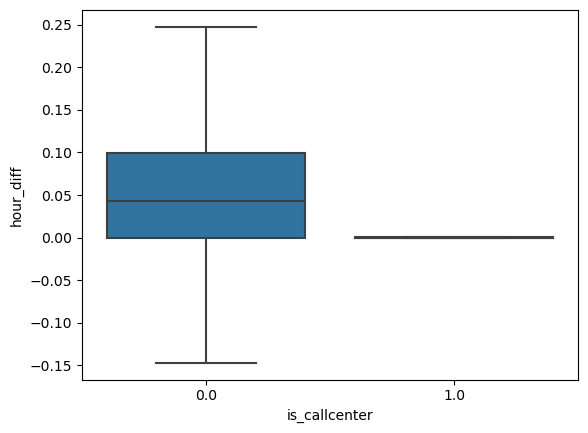

In [182]:
import seaborn as sns
ax = X_tr.hour_diff
sns.boxplot(X_tr, y=ax, x=y_tr, showfliers=False)

In [183]:
import lightgbm as lgb

tr_data = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False, categorical_feature=[] )

model_lgb = lgb.train({'eta': 0.1, 'max_depth': -1,'max_cat_to_onehot':40}, tr_data, num_boost_round=100,categorical_feature=[] )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12873
[LightGBM] [Info] Number of data points in the train set: 94595, number of used features: 87
[LightGBM] [Info] Start training from score 0.359839


In [184]:
y_pred_val_lgb = model_lgb.predict(X_val)

In [185]:
y_pred_val_lgb

array([ 0.01521499,  0.00989077,  0.99080179, ..., -0.00299599,
        0.02446955,  0.00328019])

In [186]:
from sklearn.metrics import roc_auc_score

In [187]:
score = roc_auc_score(y_val, y_pred_val_lgb)
score

0.9687630907310091

In [188]:
imp_lgb = pd.DataFrame({'featchure':X.columns, 'imp': model_lgb.feature_importance()})
imp_lgb

,featchure,imp
0,create_time,64
1,good_id_x,65
2,price_x,101
3,utm_medium,52
4,utm_source,85
...,...,...
82,pageview_numbermax,0
83,pageview_duration_secsum,9
84,pageview_duration_secmax,0
85,pageview_duration_secmin,0


In [190]:
from catboost import CatBoostClassifier

In [191]:
cat_cat = CatBoostClassifier(eval_metric='AUC',cat_features=category_feat, boosting_type = 'Plain',has_time=True,
                         max_bin=254, iterations = 300, learning_rate=0.2 )
cat_cat.fit(X_tr,y_tr)

0:	total: 280ms	remaining: 1m 23s
1:	total: 558ms	remaining: 1m 23s
2:	total: 807ms	remaining: 1m 19s
3:	total: 1.07s	remaining: 1m 19s
4:	total: 1.36s	remaining: 1m 20s
5:	total: 1.7s	remaining: 1m 23s
6:	total: 2.04s	remaining: 1m 25s
7:	total: 2.38s	remaining: 1m 26s
8:	total: 2.76s	remaining: 1m 29s
9:	total: 3.04s	remaining: 1m 28s
10:	total: 3.32s	remaining: 1m 27s
11:	total: 3.56s	remaining: 1m 25s
12:	total: 3.82s	remaining: 1m 24s
13:	total: 4.08s	remaining: 1m 23s
14:	total: 4.33s	remaining: 1m 22s
15:	total: 4.57s	remaining: 1m 21s
16:	total: 4.83s	remaining: 1m 20s
17:	total: 5.07s	remaining: 1m 19s
18:	total: 5.34s	remaining: 1m 18s
19:	total: 5.59s	remaining: 1m 18s
20:	total: 5.85s	remaining: 1m 17s
21:	total: 6.15s	remaining: 1m 17s
22:	total: 6.5s	remaining: 1m 18s
23:	total: 6.74s	remaining: 1m 17s
24:	total: 6.99s	remaining: 1m 16s
25:	total: 7.27s	remaining: 1m 16s
26:	total: 7.62s	remaining: 1m 17s
27:	total: 7.91s	remaining: 1m 16s
28:	total: 8.17s	remaining: 1m 1

239:	total: 1m 1s	remaining: 15.5s
240:	total: 1m 2s	remaining: 15.2s
241:	total: 1m 2s	remaining: 15s
242:	total: 1m 2s	remaining: 14.7s
243:	total: 1m 3s	remaining: 14.5s
244:	total: 1m 3s	remaining: 14.2s
245:	total: 1m 3s	remaining: 14s
246:	total: 1m 3s	remaining: 13.7s
247:	total: 1m 4s	remaining: 13.4s
248:	total: 1m 4s	remaining: 13.2s
249:	total: 1m 4s	remaining: 12.9s
250:	total: 1m 4s	remaining: 12.7s
251:	total: 1m 5s	remaining: 12.4s
252:	total: 1m 5s	remaining: 12.1s
253:	total: 1m 5s	remaining: 11.9s
254:	total: 1m 5s	remaining: 11.6s
255:	total: 1m 6s	remaining: 11.4s
256:	total: 1m 6s	remaining: 11.1s
257:	total: 1m 6s	remaining: 10.8s
258:	total: 1m 6s	remaining: 10.6s
259:	total: 1m 7s	remaining: 10.3s
260:	total: 1m 7s	remaining: 10.1s
261:	total: 1m 7s	remaining: 9.8s
262:	total: 1m 7s	remaining: 9.54s
263:	total: 1m 8s	remaining: 9.29s
264:	total: 1m 8s	remaining: 9.03s
265:	total: 1m 8s	remaining: 8.77s
266:	total: 1m 8s	remaining: 8.51s
267:	total: 1m 9s	remaini

In [192]:
y_pred_val = cat_cat.predict_proba(X_val)[::,1]
y_pred_class =cat_cat.predict(X_val)
y_pred_class
y_pred_val

array([0.00677456, 0.00184239, 0.99791365, ..., 0.00745245, 0.05598051,
       0.00540886])

In [193]:
score = roc_auc_score(y_val, y_pred_val)
score

0.9676183816466067

In [194]:
score = roc_auc_score(y_val, y_pred_val)
score

0.9676183816466067

In [195]:
score = roc_auc_score(y_val, (y_pred_val+y_pred_val_lgb)/2)
score

0.9695728560396302

In [196]:
imp = pd.DataFrame({'featchure':X.columns, 'imp': cat_cat.feature_importances_})
imp.sort_values(by='imp',ascending=False)

,featchure,imp
49,diff_num_pages,28.266884
33,ends_nan,24.824313
67,diff_last_date_time_create_time_sec,21.017818
46,min_diff,2.169675
77,page_typemax,2.110384
...,...,...
16,is_rated,0.000000
81,pageview_numbermin,0.000000
36,start_nan,0.000000
9,is_moderated,0.000000


In [197]:
y_val

94595     0.0
94596     0.0
94597     1.0
94598     0.0
94599     0.0
         ... 
104590    0.0
104591    0.0
104592    0.0
104593    0.0
104594    0.0
Name: is_callcenter, Length: 10000, dtype: float64

In [198]:
results = pd.DataFrame({"y_true":y_val,"y_pred":y_pred_class, "prob":y_pred_val})
results['error']=results.y_true!=results.y_pred
results[results.error]

,y_true,y_pred,prob,error
94606,1.0,0.0,0.327616,True
94610,1.0,0.0,0.229914,True
94613,1.0,0.0,0.394358,True
94642,0.0,1.0,0.574043,True
94646,1.0,0.0,0.201056,True
...,...,...,...,...
104437,0.0,1.0,0.532325,True
104488,0.0,1.0,0.540554,True
104504,0.0,1.0,0.612048,True
104544,0.0,1.0,0.627677,True


In [199]:
x_val_err=pd.concat([X_val, results], axis = 1)

In [200]:
x_val_err[(x_val_err.prob > 0.95) & (x_val_err.error)]

,create_time,good_id_x,price_x,utm_medium,utm_source,category_id_x,parent_id,root_id,model_id_x,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_rated,create_time_hour,create_time_day,create_time_month,model_create_time_hour,model_create_time_day,model_create_time_month,model_create_time_year,count_category_id,count_model_id,count_good_id,total_sec_dt,total_sec_dur,max_sec_dur,min_sec_dur,max_page_type,min_page_type,ends_nan,last_page_type,last_page_number,start_nan,first_page_type,first_page_number,session_size,price_sum,price_max,price_min,total_min_dt,total_hour_dt,sec_diff,min_diff,hour_diff,price_avg,diff_num_pages,diff_page_type_last_page_number,total_sec_dt_page1,total_sec_dur_page1,sec_diff_page1,date_time_hour,date_time_day,date_time_month,last_date_time,avg_page_type,date_time,page_type_x,pageview_number_x,pageview_duration_sec_x,product_in_sale,hour,day,month,diff_last_date_time_create_time_sec,diff_createtime_datetime_days,diff_createtime_datetime_hours,diff_createtime_datetime_avg_hours,diff_createtime_datetime_avg_days,page_type_y,pageview_number_y,pageview_duration_sec_y,page_typecount,page_typemin,page_typemax,page_typesum,page_typemedian,pageview_numbercount,pageview_numbermin,pageview_numbermax,pageview_duration_secsum,pageview_duration_secmax,pageview_duration_secmin,pageview_for_sec,y_true,y_pred,prob,error
95068,191268511.0,31113955,2197.0,2.0,NaN,134,125,124,14389721,1.0,NaN,1.0,138.0,1.0,1.0,146377043.0,1.0,18.0,23.0,1.0,4.0,22.0,8.0,1974.0,1.0,1.0,1.0,0.000,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2197.0,2197.0,2197.0,0.000000,0.000000,0.000,0.000000,0.000000,2197.000000,0.0,0.0,0.000,0.0,0.000,17.0,23.0,1.0,1.912675e+08,1.000000,1.912675e+08,1.000000,1.000000,NaN,1.0,17.000000,23.0,1.0,1.049000e-06,0.0,1.0,1.000000,0.0,1.0,1.000000,NaN,1,1.0,1.0,1.0,1.0,1,1.0,1.0,0.0,NaN,NaN,0.000000,0.0,1.0,0.978776,True
95118,191270997.0,66921579,5277.0,1.0,1.0,155,154,153,26673811,1.0,5.0,4.0,0.0,105.0,5.0,174936875.0,0.0,18.0,23.0,1.0,17.0,18.0,7.0,1975.0,3.0,2.0,2.0,61.797,62.0,32.0,30.0,2.0,1.0,1.0,1.0,3.0,0.0,2.0,1.0,3.0,10554.0,5277.0,5277.0,1.029950,0.017166,-0.203,-0.003383,-0.000056,3518.000000,0.0,1.0,31.687,32.0,-0.313,18.0,23.0,1.0,1.912701e+08,1.333333,1.912701e+08,1.333333,2.000000,31.000000,1.0,18.000000,23.0,1.0,8.810000e-07,0.0,0.0,0.000000,0.0,1.0,2.500000,32.000000,3,1.0,2.0,4.0,1.0,3,1.0,3.0,62.0,32.0,30.0,20.666667,0.0,1.0,0.992626,True
95265,191323219.0,72202547,1111.0,1.0,1.0,776,770,722,34186963,1.0,NaN,NaN,0.0,2.0,3.0,189734895.0,1.0,9.0,24.0,1.0,0.0,6.0,1.0,1976.0,3.0,3.0,3.0,2183.296,1995.0,1644.0,351.0,1.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,3.0,3333.0,1111.0,1111.0,36.388267,0.606471,188.296,3.138267,0.052304,1111.000000,1.0,3.0,2183.296,1995.0,188.296,9.0,24.0,1.0,1.913251e+08,1.000000,1.913238e+08,1.000000,2.666667,997.500000,1.0,9.000000,24.0,1.0,-1.835000e-06,0.0,0.0,0.000000,0.0,1.0,2.666667,997.500000,3,1.0,1.0,3.0,1.0,3,1.0,4.0,1995.0,1644.0,351.0,665.000000,0.0,1.0,0.996522,True
96470,191436270.0,24618379,188.0,4.0,1.0,3091,1600,1504,16569659,1.0,NaN,NaN,51.0,1.0,1.0,153658735.0,1.0,16.0,25.0,1.0,10.0,14.0,11.0,1974.0,6.0,1.0,1.0,311.800,312.0,174.0,2.0,3.0,1.0,1.0,2.0,10.0,0.0,2.0,1.0,10.0,71.0,71.0,71.0,5.196667,0.086611,-0.200,-0.003333,-0.000056,7.100000,0.0,7.0,0.000,41.0,-41.000,16.0,25.0,1.0,1.914357e+08,2.300000,1.914357e+08,2.300000,5.500000,34.666667,1.0,16.000000,25.0,1.0,5.280000e-07,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,10,1.0,3.0,23.0,2.0,10,1.0,10.0,312.0,174.0,2.0,31.200000,0.0,1.0,0.974160,True
96880,191499071.0,62594420,271.0,1.0,1.0,3451,2844,1504,20695617,1.0,NaN,NaN,514.0,1.0,2.0,164998872.0,1.0,10.0,26.0,1.0,17.0,25.0,3.0,1975.0,1.0,1.0,1.0,0.000,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,271.0,271.0,271.0,0.000000,0.000000,0.000,0.000000,0.000000,271.000000,0.0,0.0,0.000,0.0,0.000,9.0,26.0,1.0,1.914977e+08,1.000000,1.914977e+08,1.000000,1.000000,NaN,1.0,9.000000,26.0,1.0,1.331000e-06,0.0,1.0,1.000000,0.0,1.0,1.

# TEST

In [201]:
df_test =pd.read_csv("test.csv").sort_values('create_time')
df_test

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time
11701,1340768,1976-02-01 09:00:07,54795408,1939,7,11.0,131784113,1200,5674,1183,19566244,1,NaN,0.0,1520,95,6,1975-03-10 22:00:37.000
6964,1340769,1976-02-01 09:04:05,70360249,790,4,2.0,131784300,2351,2342,1634,5879298,1,NaN,NaN,68,3,3,1973-11-29 13:08:14.000
1784,1340770,1976-02-01 09:04:35,60451464,285,5,20.0,131783792,165,154,153,213245,1,NaN,0.0,861,5,1,1972-01-18 21:03:00.000
1785,1340772,1976-02-01 09:08:58,60451464,285,5,20.0,131783792,165,154,153,213245,1,NaN,0.0,861,5,1,1972-01-18 21:03:00.000
16398,1340773,1976-02-01 09:09:22,70759530,761,4,1.0,131782574,1259,5675,1183,33544040,1,NaN,NaN,0,1,2,1975-12-18 22:40:33.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,1373191,1976-02-16 20:58:39,26450612,284,1,1.0,134628420,8018,8015,1183,5771138,0,NaN,NaN,0,1,1,1973-11-27 12:11:27.000
3699,1373192,1976-02-16 20:58:42,31402098,3182,1,1.0,134624868,3416,140,124,1776800,1,NaN,NaN,0,5,4,1972-09-20 17:21:43.000
10741,1373193,1976-02-16 20:59:15,62267652,5382,2,3.0,134461968,127,125,124,17200183,1,NaN,NaN,0,2,1,1974-12-25 12:35:10.000
5409,1373194,1976-02-16 20:59:21,44792115,411,1,1.0,134627402,139,133,124,2948574,1,NaN,1.0,0,8,1,NaN


In [202]:
df_test =pd.read_csv("test.csv")
df_test['is_rated'] = df_test['rating_value'].isna().astype(int)
df_test.create_time = pd.to_datetime(df_test.create_time, errors='raise')
df_test.model_create_time = pd.to_datetime(df_test.model_create_time, errors='raise')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17196 entries, 0 to 17195
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            17196 non-null  int64         
 1   create_time         17196 non-null  datetime64[ns]
 2   good_id             17196 non-null  int64         
 3   price               17196 non-null  int64         
 4   utm_medium          17196 non-null  int64         
 5   utm_source          15653 non-null  float64       
 6   sessionkey_id       17196 non-null  int64         
 7   category_id         17196 non-null  int64         
 8   parent_id           17196 non-null  int64         
 9   root_id             17196 non-null  int64         
 10  model_id            17196 non-null  int64         
 11  is_moderated        17196 non-null  int64         
 12  rating_value        5162 non-null   float64       
 13  rating_count        7919 non-null   float64   

In [203]:
df_test['create_time_hour'] = df_test.create_time.dt.hour
df_test['create_time_day'] = df_test.create_time.dt.day
df_test['create_time_month'] = df_test.create_time.dt.month
df_test['model_create_time_hour'] = df_test.model_create_time.dt.hour
df_test['model_create_time_day'] = df_test.model_create_time.dt.day
df_test['model_create_time_month'] = df_test.model_create_time.dt.month
df_test['model_create_time_year'] = df_test.model_create_time.dt.year

In [204]:
df_test = df_test.merge(session_agg, how='left', on='sessionkey_id')

In [205]:
df_test = df_test.merge(session_agg1, how='left', on='sessionkey_id')

In [206]:
df_test = df_test.merge(session_agg2, how='left', on='sessionkey_id')

In [207]:
df_test = df_test.merge(session_agg_time, how='left', on='sessionkey_id')

In [208]:
df_test1= df_test.merge(df_info, how='left', on='sessionkey_id')

In [209]:
df_test1['diff_last_date_time_create_time_sec'] = (df_test1['create_time']-df_test1['last_date_time']).astype('timedelta64[s]')

In [210]:
dff_test = df_test1.groupby(by='order_id', as_index=False).mean()

In [211]:
dff_test['diff_createtime_datetime_days'] = dff_test['create_time_day'] - dff_test['date_time_day']
dff_test['diff_createtime_datetime_hours'] = dff_test['create_time_day']*24+dff_test['create_time_hour'] - (dff_test['date_time_day']*24+dff_test['date_time_hour'])

dff_test['diff_createtime_datetime_avg_hours'] = dff_test['create_time_day']*24+dff_test['create_time_hour'] - (dff_test['day']*24+dff_test['hour'])
dff_test['diff_createtime_datetime_avg_days'] = dff_test['create_time_day'] - dff_test['day']

In [212]:
len(df_test1), len(df_test)

(245382, 17196)

In [213]:
dff_test1 = df_test1.groupby(by='order_id', as_index=False).agg({'page_type':['count', 'min','max','sum','median'],'pageview_number':['count', 'min','max'],'pageview_duration_sec':['sum', 'max', 'min'],})

In [214]:
df_test_true = pd.DataFrame(df_test.order_id)
df_test_true = df_test_true.merge(dff_test, how='left', on='order_id')

In [215]:
dff_test2 = df_test1[(df_test1.price_x==df_test1.price_y)]
dff_test2 = dff_test2[['order_id','page_type','pageview_number','pageview_duration_sec']]
dff_test2

,order_id,page_type,pageview_number,pageview_duration_sec
0,1350922,1.0,1.0,62.0
2,1354989,1.0,1.0,872.0
5,1352637,1.0,1.0,979.0
8,1350050,1.0,1.0,337.0
9,1350050,1.0,2.0,1046.0
...,...,...,...,...
245326,1349045,1.0,9.0,88.0
245335,1349045,1.0,22.0,30.0
245343,1357968,1.0,2.0,105.0
245346,1358835,1.0,2.0,18.0


In [216]:
dff_test2 = dff_test2.groupby(by='order_id', as_index=False).mean()

In [217]:
df_test_true=df_test_true.merge(dff_test2, on='order_id', how='left')

In [218]:
dff_test1.columns = list(map(''.join, dff_test1.columns.values))
dff_test1['pageview_for_sec'] = dff_test1['pageview_duration_secsum']/dff_test1['pageview_numbercount']
dff_test1

,order_id,page_typecount,page_typemin,page_typemax,page_typesum,page_typemedian,pageview_numbercount,pageview_numbermin,pageview_numbermax,pageview_duration_secsum,pageview_duration_secmax,pageview_duration_secmin,pageview_for_sec
0,1340768,5,1.0,6.0,14.0,3.0,5,1.0,8.0,97.0,33.0,13.0,19.400000
1,1340769,5,1.0,6.0,14.0,2.0,5,1.0,11.0,158.0,83.0,13.0,31.600000
2,1340770,32,1.0,7.0,77.0,2.0,32,1.0,35.0,656.0,72.0,6.0,20.500000
3,1340772,32,1.0,7.0,77.0,2.0,32,1.0,35.0,656.0,72.0,6.0,20.500000
4,1340773,5,1.0,2.0,9.0,2.0,5,1.0,5.0,113.0,63.0,7.0,22.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17191,1373191,5,1.0,5.0,14.0,3.0,5,1.0,8.0,93.0,45.0,4.0,18.600000
17192,1373192,9,1.0,9.0,24.0,2.0,9,1.0,9.0,710.0,360.0,7.0,78.888889
17193,1373193,9,2.0,8.0,33.0,2.0,9,1.0,9.0,175.0,81.0,4.0,19.444444
17194,1373194,7,1.0,6.0,31.0,6.0,7,1.0,9.0,244.0,109.0,1.0,34.857143


In [219]:
df_test_true=df_test_true.merge(dff_test1, on='order_id', how='left')

In [220]:
df_test_true = df_test_true.drop(['sessionkey_id','category_id_y','model_id_y','good_id_y','price_y','order_id' ], axis=1)

In [221]:
# catrgory_feat=['good_id_x','category_id_x','parent_id','root_id','model_id_x']
# # catrgory_feat=[]
df_test_true[category_feat] = df_test_true[category_feat].astype('int').astype('category')


In [222]:
# df_test_true=df_test_true[['diff_num_pages','diff_last_date_time_create_time_sec','ends_nan','hour_diff']]

# Тrain all and predict test

In [223]:
cat = CatBoostClassifier(eval_metric='AUC',cat_features=category_feat, boosting_type = 'Plain',has_time=True,
                         max_bin=254, iterations = 300, learning_rate=0.2 )
cat.fit(X,y)

0:	total: 239ms	remaining: 1m 11s
1:	total: 473ms	remaining: 1m 10s
2:	total: 722ms	remaining: 1m 11s
3:	total: 978ms	remaining: 1m 12s
4:	total: 1.22s	remaining: 1m 12s
5:	total: 1.47s	remaining: 1m 12s
6:	total: 1.71s	remaining: 1m 11s
7:	total: 1.97s	remaining: 1m 11s
8:	total: 2.17s	remaining: 1m 10s
9:	total: 2.38s	remaining: 1m 9s
10:	total: 2.61s	remaining: 1m 8s
11:	total: 2.83s	remaining: 1m 7s
12:	total: 3.04s	remaining: 1m 7s
13:	total: 3.28s	remaining: 1m 7s
14:	total: 3.52s	remaining: 1m 6s
15:	total: 3.75s	remaining: 1m 6s
16:	total: 3.96s	remaining: 1m 6s
17:	total: 4.16s	remaining: 1m 5s
18:	total: 4.41s	remaining: 1m 5s
19:	total: 4.62s	remaining: 1m 4s
20:	total: 4.83s	remaining: 1m 4s
21:	total: 5.04s	remaining: 1m 3s
22:	total: 5.26s	remaining: 1m 3s
23:	total: 5.5s	remaining: 1m 3s
24:	total: 5.75s	remaining: 1m 3s
25:	total: 5.95s	remaining: 1m 2s
26:	total: 6.14s	remaining: 1m 2s
27:	total: 6.36s	remaining: 1m 1s
28:	total: 6.56s	remaining: 1m 1s
29:	total: 6.78s

240:	total: 53s	remaining: 13s
241:	total: 53.2s	remaining: 12.7s
242:	total: 53.4s	remaining: 12.5s
243:	total: 53.7s	remaining: 12.3s
244:	total: 53.9s	remaining: 12.1s
245:	total: 54.2s	remaining: 11.9s
246:	total: 54.4s	remaining: 11.7s
247:	total: 54.6s	remaining: 11.4s
248:	total: 54.8s	remaining: 11.2s
249:	total: 55s	remaining: 11s
250:	total: 55.1s	remaining: 10.8s
251:	total: 55.2s	remaining: 10.5s
252:	total: 55.4s	remaining: 10.3s
253:	total: 55.5s	remaining: 10s
254:	total: 55.6s	remaining: 9.81s
255:	total: 55.7s	remaining: 9.57s
256:	total: 55.8s	remaining: 9.33s
257:	total: 55.9s	remaining: 9.09s
258:	total: 56s	remaining: 8.86s
259:	total: 56.1s	remaining: 8.63s
260:	total: 56.2s	remaining: 8.4s
261:	total: 56.4s	remaining: 8.19s
262:	total: 56.7s	remaining: 7.97s
263:	total: 56.9s	remaining: 7.76s
264:	total: 57.1s	remaining: 7.54s
265:	total: 57.3s	remaining: 7.33s
266:	total: 57.5s	remaining: 7.11s
267:	total: 57.8s	remaining: 6.9s
268:	total: 58s	remaining: 6.68s
2

In [224]:
df_test_true.create_time  = df_test_true.create_time.astype('int64')/10**9
df_test_true.model_create_time  = df_test_true.model_create_time.astype('int64')/10**9
df_test_true.last_date_time  = df_test_true.last_date_time.astype('int64')/10**9
df_test_true.date_time  = df_test_true.date_time.astype('int64')/10**9
df_test_true.diff_last_date_time_create_time_sec  = df_test_true.diff_last_date_time_create_time_sec.astype('int64')/10**9

In [225]:
y_pred_cat = cat_cat.predict_proba(df_test_true)[::,1]
y_pred_cat

array([0.00508066, 0.00418696, 0.57806492, ..., 0.94066132, 0.04596553,
       0.00221724])

In [226]:
df_sub1 = pd.read_csv('sample_submission.csv')
df_sub1.is_callcenter=y_pred_cat
df_sub1.to_csv('submission_cat.csv', index=False)

In [227]:
df_sub1

,order_id,is_callcenter
0,1350922,0.005081
1,1354989,0.004187
2,1352637,0.578065
3,1350050,0.615012
4,1341733,0.160356
...,...,...
17191,1358397,0.135142
17192,1357968,0.016926
17193,1358835,0.940661
17194,1365692,0.045966


In [228]:
import lightgbm as lgb

tr_data = lgb.Dataset(X, label=y, free_raw_data=False, categorical_feature=[])

model = lgb.train({'eta': 0.1, 'max_depth': -1,'max_cat_to_onehot':20}, tr_data, num_boost_round=100,categorical_feature=[])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12960
[LightGBM] [Info] Number of data points in the train set: 104595, number of used features: 87
[LightGBM] [Info] Start training from score 0.354692


In [229]:
y_pred_lgb = model_lgb.predict(df_test_true)

In [230]:
df_sub = pd.read_csv('sample_submission.csv')
df_sub.is_callcenter=y_pred_lgb
df_sub.to_csv('submission_lgb.csv', index=False)

In [231]:
df_sub

,order_id,is_callcenter
0,1350922,0.076978
1,1354989,-0.071524
2,1352637,0.476979
3,1350050,0.359771
4,1341733,0.255514
...,...,...
17191,1358397,0.252648
17192,1357968,0.036368
17193,1358835,0.924636
17194,1365692,0.202561


In [232]:
df_sub = pd.read_csv('sample_submission.csv')
df_sub.is_callcenter=(y_pred_lgb+y_pred_cat)/2
df_sub.to_csv('submission_lgb_cat.csv', index=False)

In [233]:
# !kaggle competitions submit -c aim-2023-callcenter -f submission_lgb_cat.csv -m "lgb_cat"